# OLS vs. Lasso

This notebook presents a simple implementation of Lasso and elastic net regressions. It uses the [OSQP.jl](https://github.com/osqp/OSQP.jl) package for the numerical optimisation.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, LinearAlgebra, SparseArrays, Statistics, OSQP

include("jlFiles/printmat.jl")
include("jlFiles/RidgeRegression.jl")
include("jlFiles/LassoElasticNet.jl")

LassoEN

In [2]:
using Plots, LaTeXStrings

gr(size=(480,320))
default(fmt = :png)

# Loading Data

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN             = Date.(x[:,1],"yyyy-mm-dd")       #convert to Date
(Rb,RFunds,Rf) = (convert.(Float64,x[:,2:9]),convert.(Float64,x[:,10:11]),
                  convert.(Float64,x[:,12]));     #convert to Float64

# An Elastic Net Regression

minimizes a combination of the Lasso and Ridge regression loss functions

$(Y-Xb)'(Y-Xb)/T + \gamma \sum |b_i-\beta_{i0}| + \lambda \sum (b_i-\beta_{i0})^2$, 

where $\beta_{i0}$ is the target for coefficient $i$ (defaults to 0). Set $\lambda=0,\gamma>0$ to get a *Lasso* regression or instead $\lambda>0,\gamma=0$ to get a *ridge* regression.

Notice that we divide the sum of squared residuals by $T$. This helps the interpretation of the $\gamma$ and $\lambda$ values.

The problem is reformulated (see the code below) as a linear-quadratic problems with restrictions (see below). The code uses the `OSQP.jl` solver.

The function `LassoEN()`  (included above) implements this.

# Lasso Regression

The next cell makes a Lasso regression for a single value of γ. The dependent variable is the (return of the) first mutual fund in `RFunds` (see data loading) and the regressors are (returns on) a number of benchmark portfolios (again, see data loading).

The data is standardised to have zero mean and unit variance before the estimation, by using the `StandardiseYX()` function (included above).

In [4]:
(Y,X) = StandardiseYX(RFunds[:,1],Rb)

γ = 0.05
(b,b_ls) = LassoEN(Y,X,γ)

printblue("OLS and Lasso coeffs (with γ=$γ):\n")
printmat(b_ls,b;colNames=["OLS","Lasso"],rowNames=IndNames,width=15)

OLS and Lasso coeffs (with γ=0.05):



                                      OLS          Lasso
S&P 500                             0.513          0.502
S&P MidCap 400                      0.117          0.128
S&P Small Cap 600                   0.097          0.079
World Developed - Ex. U.S.          0.239          0.244
Emerging Markets                    0.080          0.077
US Corporate Bonds                  0.061          0.000
U.S. Treasury Bills                 0.002          0.000
US Treasury                        -0.045         -0.000



# Redo the Lasso Regression with different γ (gamma) Values

The function `LassoEN()` can loop over $\gamma$ values (and exploit the fact that this only requires a partial updating of the problem).

You can also change the target level $\beta_0$ to be something else than zero.

In [5]:
nγ = 51
γM = range(0,0.5,length=nγ)
β₀ = 0.0     #change to eg. 0.1 to set another target, or specify a vector

bLasso, = LassoEN(Y,X,γM,0,β₀);
#printmat([γM bLasso'])

([0.5133090040725734 0.5106180377131523 … 0.4255026373445663 0.4240666529958661; 0.11698665152092119 0.12047673396116063 … 0.15115511661839562 0.1494923891739515; … ; 0.0024326280722570476 7.768698732738037e-6 … -1.7670608274156849e-6 -1.7670608272905453e-6; -0.045422944401110624 -0.01726334607755956 … -7.422653751658316e-6 -7.42265375210122e-6], [0.5133165170513289, 0.11696664445666557, 0.09695043688908764, 0.23935782546545695, 0.08047689846904352, 0.06106163208423495, 0.002432837169294009, -0.045422878560020835])

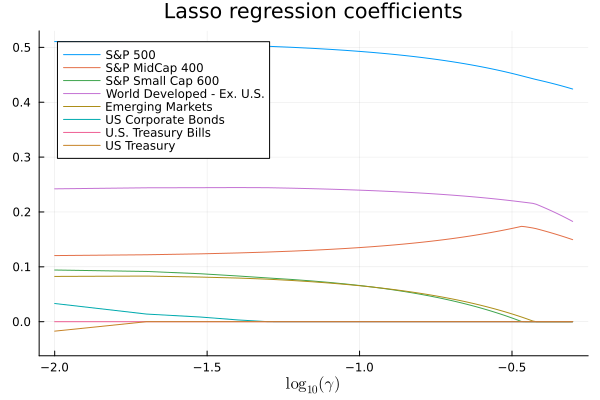

In [6]:
p1 = plot( log10.(γM),bLasso',
           title = "Lasso regression coefficients",
           xlabel = L"\log_{10}(\gamma)",
           label = permutedims(IndNames),
           legend = :topleft,
           size = (600,400) )
display(p1)

# A Ridge Regression

minimizes 

$(Y-Xb)'(Y-Xb)/T + \lambda \sum (b_i-\beta_{i0})^2,$

where $\beta_{i0}$ is the target for coefficient $i$ (defaults to 0). We compare the results from using linear algrebra and optimization based ones from the `LassoEN()` function. A function for this is included above.

In [7]:
β₀ = 0              #change to eg. 0.1 to set another target

b_LS     = X\Y
b_ridge  = RidgeRegression(Y,X,0.1,β₀)
b_ridge2, = LassoEN(Y,X,0,0.1,β₀)

printblue("OLS and ridge regression:\n")
printmat(b_ls,b_ridge,b_ridge2;colNames=["OLS","analytical ridge","numerical ridge"],rowNames=IndNames,width=20)

OLS and ridge regression:

                                           OLS    analytical ridge     numerical ridge
S&P 500                                  0.513               0.375               0.375
S&P MidCap 400                           0.117               0.192               0.192
S&P Small Cap 600                        0.097               0.129               0.129
World Developed - Ex. U.S.               0.239               0.229               0.229
Emerging Markets                         0.080               0.102               0.102
US Corporate Bonds                       0.061               0.048               0.048
U.S. Treasury Bills                      0.002              -0.001              -0.001
US Treasury                             -0.045              -0.036              -0.036



In [8]:
nλ = 51
λM = range(0,10,length=nλ)

bridge   = fill(NaN,size(X,2),nλ)
for i = 1:nλ                          #loop over λ values
    bridge[:,i] = RidgeRegression(Y,X,λM[i])
end

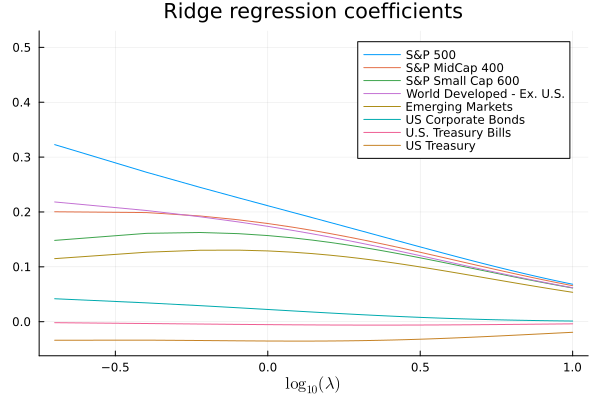

In [9]:
p1 = plot( log10.(λM),bridge',
           title = "Ridge regression coefficients",
           xlabel = L"\log_{10}(\lambda)",
           label = permutedims(IndNames),
           size = (600,400) )
display(p1)

# An Elastic Net Regression

In [10]:
λ = 0.2
bEN, = LassoEN(Y,X,γM,λ);

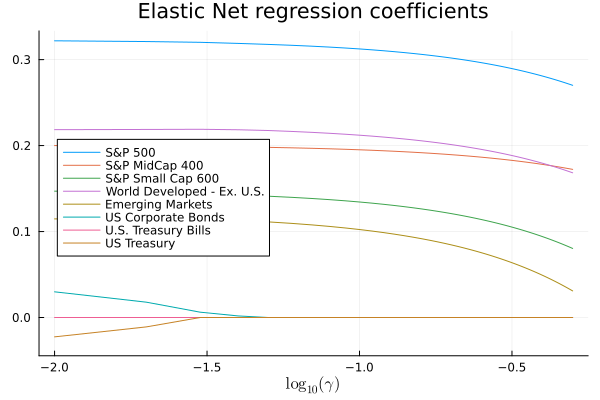

In [11]:
p1 = plot( log10.(γM),bEN',
           title = "Elastic Net regression coefficients",
           xlabel = L"\log_{10}(\gamma)",
           label = permutedims(IndNames),
           legend = :left,
           size = (600,400) )
display(p1)